# Domain-size dependence

What happens if I put in a **mass sink of a fixed-size**, with a fixed deformation radius, and vary the domain size??

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from shallow_water import PeriodicLinearShallowWater
from plotting import plot_wind_arrows

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [47]:
def run_linear_model(beta=2.28e-11, equivalent_depth=10, exp_forcing=False, 
                     scale_domain=1, Q0=3, xscale=1, yscale=2, matgill_yexp=2):
    """
    Params:
    
     - Radius of deformation: Rd = sqrt(2 c / beta)
     - beta
     
     
    # Question: What is the best thing to interpret as a 'free parameter'?
    
    Currently, James views Rd as a free parameter, but really that should be
    SET by the beta parameter and equivalent depth, right? That is much
    more physical I think. Will try to adapt the code. :)
    """
    nx = 256
    ny = nx//2 + 1


    # Radius of deformation: Rd = sqrt(2 c / beta)
    #Rd = 1000.0e3  # Fix Rd at 1000km

    Lx = scale_domain*10e6 
    Ly = scale_domain*5e6 

    
    g = 9.81
    # Kelvin wave speed: c = sqrt(gh)
    c = np.sqrt(g*equivalent_depth)  # Rd**2 * beta

    Rd = np.sqrt(c/beta) # Equatorial deformation radius
    print(f"Equatorial deformation radius = {Rd/1e3} (km)")
    
    H = c**2/g       # Set phi baseline from deformation radius

    cfl = 0.7         # For numerical stability CFL = |u| dt / dx < 1.0
    dx  = Ly / nx
    dt = np.floor(cfl * dx / (c*4))

    tau = 500000
    nu = 1000

    atmos = PeriodicLinearShallowWater(nx, ny, Lx, Ly, beta=beta, f0=0.0, g=g, H=H, dt=dt, nu=nu)

    # divide by Rd would mean size of perturbation scales with Rd
    # which is not what we're interested in...
    # So instead just scale by 1000km
    x, y = np.meshgrid(atmos.phix/1e6, atmos.phiy/1e6) 
    kx = xscale*np.pi/2
    ky = yscale*np.pi/2
    # Added -ve sign so it's representative of the low-level flow
    # i.e. a negative pressure anom (from deep convection)
    
    if exp_forcing:
        Q = -1*(Q0*np.exp(-(1/2)*y**matgill_yexp)*np.cos(kx*x)) 
        Q[np.abs(x) > 1/xscale] = 0 # Make this more general...the ">1" clause DEPENDS on `k` I think?
        
    else:
        Q = -1*(Q0*np.cos(ky*x)*np.cos(kx*x)) 
        Q[np.abs(x) > 1/xscale] = 0 # Make this more general...the ">1" clause DEPENDS on `k` I think?
        Q[np.abs(y) > 1/yscale] = 0 # Make this more general...the ">1" clause DEPENDS on `k` I think?
    
    Q = Q.T

    @atmos.add_forcing
    def matsuno_gill(model):    
        u, v, h = model.state
        du, dv, dh = np.zeros_like(model.state)

        # forcing terms for the linear matsuno gill problem
        du = - u/tau
        dv = - v/tau
        dh = (Q - h)/tau

        return np.array([du, dv, dh])


    N = int(tau/dt*3)
    for i in range(N):
        atmos.step()
        if i%int(N*0.1)==0:
            print(i)

    da_forcing = xr.DataArray(Q.T, dims=['y', 'x'],
                              coords={'x': xr.DataArray(atmos.phix[:,0]/1e3, 
                                                        dims=['x'],
                                                        attrs={'units':'km'}),
                                      'y': xr.DataArray(atmos.phiy[0,:]/1e3, 
                                                        dims=['y'],
                                                        attrs={'units':'km'})})
    
    da_height = xr.DataArray(atmos.h.T, dims=['y', 'x'],
                             coords={'x': xr.DataArray(atmos.phix[:,0]/1e3, 
                                                       dims=['x'],
                                                       attrs={'units':'km'}),
                                     'y': xr.DataArray(atmos.phiy[0,:]/1e3, 
                                                       dims=['y'],
                                                       attrs={'units':'km'})})

    return atmos, da_height, da_forcing


In [48]:
%%time
atmos_betax2, height_betax2, forcing_betax2 = run_linear_model(yscale=2, xscale=4, beta=2.28e-11*2)

atmos_betax2_halfdom, height_betax2_halfdom, forcing_betax2_halfdom = run_linear_model(yscale=2, xscale=4, 
                                                                                       scale_domain=0.5,
                                                                                       beta=2.28e-11*2)

Equatorial deformation radius = 466.0524877151881 (km)
0


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/arakawac.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([self.u, self.v, self.phi])
/home/users/andreww/miniconda3/envs/plumeworld/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/shallow_water.py:192: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

434
868
1302
1736
2170
2604
3038
3472
3906
4340
Equatorial deformation radius = 466.0524877151881 (km)
0
872
1744
2616
3488
4360
5232
6104
6976
7848
CPU times: user 1min 17s, sys: 1.24 s, total: 1min 18s
Wall time: 1min 18s


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/plotting.py:30: RuntimeWarning: divide by zero encountered in true_divide
  np.ma.masked_where(velnorm.T < hide_below, (v / np.sqrt(velmax**2 - u**2)).T)[arrow_spacing],


Text(0.5, 1.0, 'L$_{d}$ = 466 km')

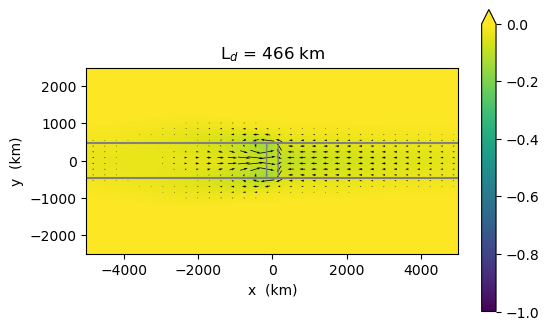

In [49]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

#(height_betax2-height_betax2.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')
height_betax2.plot(ax=ax, vmin=-1, vmax=0)
forcing_betax2.plot.contour(ax=ax, levels=[-1*abs(forcing_betax2).max()/2], 
                     colors='grey', 
                     linestyles='-', linewidths=1)

x,y=np.meshgrid(height_betax2.x, height_betax2.y)
plot_wind_arrows(atmos_betax2, (x,y), narrows=(30,30), hide_below=0.05, color='k')

ax.hlines(y=466, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-466, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')


ax.set_title(r"L$_{d}$ = 466 km")

Text(0.5, 1.0, 'L$_{d}$ = 466 km, halved domain')

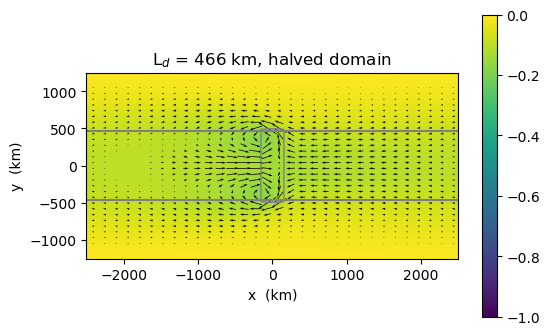

In [50]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

#(height_betax2-height_betax2.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')
height_betax2_halfdom.plot(ax=ax, vmin=-1, vmax=0)
forcing_betax2_halfdom.plot.contour(ax=ax, levels=[-1*abs(forcing_betax2_halfdom).max()/2], 
                                    colors='grey', 
                                    linestyles='-', linewidths=1)

x,y=np.meshgrid(height_betax2_halfdom.x, height_betax2_halfdom.y)
plot_wind_arrows(atmos_betax2_halfdom, (x,y), narrows=(30,30), hide_below=0.05, color='k')

ax.hlines(y=466, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-466, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')


ax.set_title(r"L$_{d}$ = 466 km, halved domain")

# This looks good, but it is still too big to simulate in a cloud-resolving model...

Make the forcing have a smaller meridional scale?

In [52]:
%%time

atmos_smallQ, height_smallQ, forcing_smallQ = run_linear_model(yscale=1,
                                                                xscale=1, 
                                                                scale_domain=0.5,
                                                                beta=2.28e-11*2)

atmos_smallQdom, height_smallQdom, forcing_smallQdom = run_linear_model(yscale=1,
                                                                        xscale=1, 
                                                                        scale_domain=0.25,
                                                                        beta=2.28e-11*2)

Equatorial deformation radius = 466.0524877151881 (km)
0


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/arakawac.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([self.u, self.v, self.phi])
/home/users/andreww/miniconda3/envs/plumeworld/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/shallow_water.py:192: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

872
1744
2616
3488
4360
5232
6104
6976
7848
Equatorial deformation radius = 466.0524877151881 (km)
0
1744
3488
5232
6976
8720
10464
12208
13952
15696
17440
CPU times: user 2min 35s, sys: 2.63 s, total: 2min 37s
Wall time: 2min 37s


Text(0.5, 1.0, 'L$_{d}$ = 466 km, 0.5xdomain, smaller forcing')

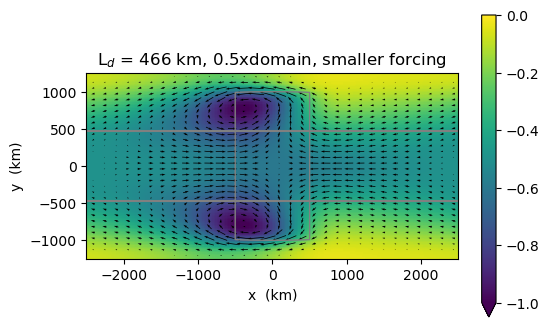

In [53]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

#(height_betax2-height_betax2.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')
height_smallQ.plot(ax=ax, vmin=-1, vmax=0)
forcing_smallQ.plot.contour(ax=ax, levels=[-1*abs(forcing_smallQ).max()/2], 
                                    colors='grey', 
                                    linestyles='-', linewidths=1)

x,y=np.meshgrid(height_smallQ.x, height_smallQ.y)
plot_wind_arrows(atmos_smallQ, (x,y), narrows=(30,30), hide_below=0.05, color='k')

ax.hlines(y=466, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-466, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')


ax.set_title(r"L$_{d}$ = 466 km, 0.5xdomain, smaller forcing")

Text(0.5, 1.0, 'L$_{d}$ = 466 km, 0.25xdomain, smaller forcing')

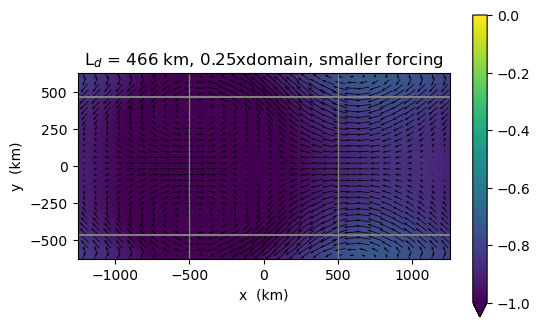

In [54]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

#(height_betax2-height_betax2.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')
height_smallQdom.plot(ax=ax, vmin=-1, vmax=0)
forcing_smallQdom.plot.contour(ax=ax, levels=[-1*abs(forcing_smallQdom).max()/2], 
                                    colors='grey', 
                                    linestyles='-', linewidths=1)

x,y=np.meshgrid(height_smallQdom.x, height_smallQdom.y)
plot_wind_arrows(atmos_smallQdom, (x,y), narrows=(30,30), hide_below=0.05, color='k')

ax.hlines(y=466, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-466, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')


ax.set_title(r"L$_{d}$ = 466 km, 0.25xdomain, smaller forcing")

# What about an ~0(50km) forcing?

In [ ]:
%%time

atmos_smallerQdom, height_smallerQdom, forcing_smallerQdom = run_linear_model(yscale=8,
                                                                              xscale=6, 
                                                                              scale_domain=0.25,
                                                                              beta=2.28e-11*2)

Equatorial deformation radius = 466.0524877151881 (km)
0


/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/arakawac.py:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([self.u, self.v, self.phi])
/home/users/andreww/miniconda3/envs/plumeworld/lib/python3.7/site-packages/ipykernel_launcher.py:75: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/gws/nopw/j04/aopp/andreww/DPhil_misc/MatGill_CRM/shallow_water_model/shallow_water.py:192: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

1744
3488
5232
6976
8720
10464


In [ ]:
fig, ax = plt.subplots(dpi=100, figsize=(6, 4))

#(height_betax2-height_betax2.mean()).plot(ax=ax, vmin=-0.2, vmax=0.2, cmap='coolwarm')
height_smallerQdom.plot(ax=ax, vmin=-1, vmax=0)
forcing_smallerQdom.plot.contour(ax=ax, levels=[-1*abs(forcing_smallerQdom).max()/2], 
                                    colors='grey', 
                                    linestyles='-', linewidths=1)

x,y=np.meshgrid(height_smallerQdom.x, height_smallerQdom.y)
plot_wind_arrows(atmos_smallerQdom, (x,y), narrows=(30,30), hide_below=0.05, color='k')

ax.hlines(y=466, xmin=-5000, xmax=5000, color='grey')
ax.hlines(y=-466, xmin=-5000, xmax=5000, color='grey')

ax.set_aspect('equal')
ax.set_xlabel('x  (km)')
ax.set_ylabel('y  (km)')


ax.set_title(r"L$_{d}$ = 466 km, 0.25xdomain," +"\n"+ r"$\sim \mathcal{O}(100 \mathrm{km})$ forcing size")

In [ ]:
forcing_smallerQdom.plot()

# Now, reduce the deformation radius by spinning faster

In [76]:
yscale=8
xscale=6
# divide by Rd would mean size of perturbation scales with Rd
# which is not what we're interested in...
# So instead just scale by 1000km
x, y = np.meshgrid(atmos_smallerQdom.phix/1e6, atmos_smallerQdom.phiy/1e6) 
kx = xscale*np.pi/2
ky = yscale*np.pi/2
# Added -ve sign so it's representative of the low-level flow
# i.e. a negative pressure anom (from deep convection)
#Q = -1*(2.5*np.exp(-(1/2)*y**matgill_yexp)*np.cos(k*x)) 
Q = -1*(2.5)*np.cos(ky*y)*np.cos(kx*x)
Q[np.abs(x) > 1/xscale] = 0 # Make this more general...the ">1" clause DEPENDS on `k` I think?
Q[np.abs(y) > 1/yscale] = 0
Q = Q.T

"\nxr.DataArray(Q.T, dims=['y', 'x'],\n              coords={'x': xr.DataArray(atmos_betax2_yexp20.phix[:,0]/1e3, \n                                        dims=['x'],\n                                        attrs={'units':'km'}),\n                      'y': xr.DataArray(atmos_betax2_yexp20.phiy[0,:]/1e3, \n                                        dims=['y'],\n                                        attrs={'units':'km'})}).sel(x=100, method='nearest').plot()\n"

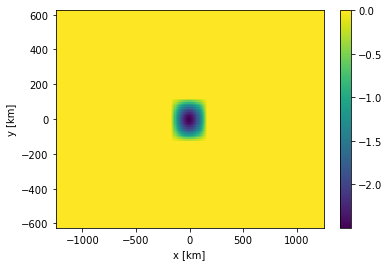

In [78]:
xr.DataArray(Q.T, dims=['y', 'x'],
              coords={'x': xr.DataArray(atmos_smallerQdom.phix[:,0]/1e3, 
                                        dims=['x'],
                                        attrs={'units':'km'}),
                      'y': xr.DataArray(atmos_smallerQdom.phiy[0,:]/1e3, 
                                        dims=['y'],
                                        attrs={'units':'km'})}).plot()

"""
xr.DataArray(Q.T, dims=['y', 'x'],
              coords={'x': xr.DataArray(atmos_betax2_yexp20.phix[:,0]/1e3, 
                                        dims=['x'],
                                        attrs={'units':'km'}),
                      'y': xr.DataArray(atmos_betax2_yexp20.phiy[0,:]/1e3, 
                                        dims=['y'],
                                        attrs={'units':'km'})}).sel(x=100, method='nearest').plot()
"""

#plt.ylim(-100,100)
#plt.xlim(-100,100)